In [83]:
import shap
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import category_encoders as ce
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Task №1: 📊 **Анализ ошибок**

In [84]:
def bank_customer():
    bank_df = pd.read_csv("Bank Customer Churn Prediction.csv")
    return bank_df
data = bank_customer()
print(data.shape)
data.head()

(10000, 12)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [85]:
cat_features = ['country', 'gender', 'tenure', 'products_number', 'credit_card', 'active_member']

def build_bank_model(data, cat_features):
    bank_df = data.copy()
    cat_features = cat_features

    X = bank_df.drop(['churn'], axis=1)
    y = bank_df['churn']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

    model = CatBoostClassifier(random_state=123, 
                           depth=5,
                           iterations=100, 
                           eval_metric='AUC', 
                           verbose=0,
                           cat_features=cat_features)
    model.fit(train_pool, eval_set=test_pool, plot=True)
    
    y_pred_proba_test = model.predict_proba(test_pool)[:, 1]
    auc_test = roc_auc_score(y_test, y_pred_proba_test)

    y_pred_proba_train = model.predict_proba(train_pool)[:, 1]
    auc_train = roc_auc_score(y_train, y_pred_proba_train)

    return model, X_train, X_test, y_train, y_test, auc_train, auc_test
    
model, X_train, X_test, y_train, y_test, auc_train, auc_test = build_bank_model(data, cat_features)

auc_train_a = auc_train
auc_test_a = auc_test
print(f"AUC (Train): {auc_train}")
print(f"AUC (Test): {auc_test}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

AUC (Train): 0.8855094483209535
AUC (Test): 0.8777359231479327


In [86]:
def compute_auc_per_category(model, X_train, y_train, X_test, y_test, cat_features):
    unique_categories = X_train[cat_features].unique()
    results = []
    
    for category in unique_categories:
        train_indices = X_train[cat_features] == category
        test_indices = X_test[cat_features] == category
        
        train_count = np.sum(train_indices)
        test_count = np.sum(test_indices)
        
        try:
            train_auc = roc_auc_score(y_train[train_indices], model.predict_proba(X_train[train_indices])[:, 1])
            test_auc = roc_auc_score(y_test[test_indices], model.predict_proba(X_test[test_indices])[:, 1])
        except ValueError:
            train_auc = np.nan
            test_auc = np.nan

        results.append([category, train_count, train_auc, test_count, test_auc])

    return results

def plot_auc_per_category(model, X_train, y_train, X_test, y_test, cat_features):
    for feature in cat_features:
        results = compute_auc_per_category(model, X_train, y_train, X_test, y_test, feature)
        df_results = pd.DataFrame(results, columns=['Category', 'Train Count', 'Train AUC', 'Test Count', 'Test AUC'])
        
        df_results['AUC Difference'] = df_results['Train AUC'] - df_results['Test AUC']
        df_results_sorted = df_results.sort_values(by='AUC Difference', ascending=False)
        
        print(f"\nAUC and Counts for {feature} sorted by AUC difference:\n")
        display(df_results_sorted.drop(['AUC Difference'], axis=1))
        print("\n" + "-" * 50 + "\n")

plot_auc_per_category(model, X_train, y_train, X_test, y_test, cat_features=cat_features)


AUC and Counts for country sorted by AUC difference:



,Category,Train Count,Train AUC,Test Count,Test AUC
0,France,3994,0.880730,1020,0.856926
1,Germany,2011,0.882519,498,0.869975
2,Spain,1995,0.867483,482,0.884900



--------------------------------------------------


AUC and Counts for gender sorted by AUC difference:



,Category,Train Count,Train AUC,Test Count,Test AUC
1,Female,3638,0.877775,905,0.865368
0,Male,4362,0.887209,1095,0.883917



--------------------------------------------------


AUC and Counts for tenure sorted by AUC difference:



,Category,Train Count,Train AUC,Test Count,Test AUC
5,8,805,0.889201,220,0.828518
1,4,803,0.878674,186,0.827648
7,5,829,0.899559,183,0.866395
9,10,393,0.893106,97,0.866397
4,1,815,0.916522,220,0.901150
0,6,777,0.870371,190,0.864266
2,3,801,0.888849,208,0.885054
3,9,768,0.895300,216,0.894495
8,7,832,0.871442,196,0.926866
10,0,333,0.836462,80,0.894359



--------------------------------------------------


AUC and Counts for products_number sorted by AUC difference:



,Category,Train Count,Train AUC,Test Count,Test AUC
0,2,3690,0.843629,900,0.799681
2,3,213,0.927141,53,0.899267
1,1,4052,0.841063,1032,0.852380
3,4,45,NaN,15,NaN



--------------------------------------------------


AUC and Counts for credit_card sorted by AUC difference:



,Category,Train Count,Train AUC,Test Count,Test AUC
0,1,5628,0.886587,1427,0.872682
1,0,2372,0.882671,573,0.891345



--------------------------------------------------


AUC and Counts for active_member sorted by AUC difference:



,Category,Train Count,Train AUC,Test Count,Test AUC
0,1,4102,0.869396,1049,0.845430
1,0,3898,0.887841,951,0.890859



--------------------------------------------------



По результатам вычисления AUC, категории таковых, где модель показывает слабую производительность не имеются

# Task №2: 🛠 **Инженерия признаков**

In [87]:
data_frame = data.copy()
data_frame.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [88]:
from sklearn.preprocessing import PolynomialFeatures

numeric_features = data_frame[['credit_score', 'age', 'estimated_salary']]

poly = PolynomialFeatures(degree=4, include_bias=False, interaction_only=False)

poly_features = poly.fit_transform(numeric_features)
poly_feature_names = poly.get_feature_names_out(input_features=numeric_features.columns)
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)
result_df = pd.concat([data_frame, poly_df], axis=1)

print(result_df.shape)
result_df.head()

(10000, 46)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,credit_score,age,estimated_salary,credit_score^2,credit_score age,credit_score estimated_salary,age^2,age estimated_salary,estimated_salary^2,credit_score^3,credit_score^2 age,credit_score^2 estimated_salary,credit_score age^2,credit_score age estimated_salary,credit_score estimated_salary^2,age^3,age^2 estimated_salary,age estimated_salary^2,estimated_salary^3,credit_score^4,credit_score^3 age,credit_score^3 estimated_salary,credit_score^2 age^2,credit_score^2 age estimated_salary,credit_score^2 estimated_salary^2,credit_score age^3,credit_score age^2 estimated_salary,credit_score age estimated_salary^2,credit_score estimated_salary^3,age^4,age^3 estimated_salary,age^2 estimated_salary^2,age estimated_salary^3,estimated_salary^4
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,619.0,42.0,101348.88,383161.0,25998.0,62734956.72,1764.0,4256652.96,1.027160e+10,237176659.0,16092762.0,3.883294e+10,1091916.0,2.634868e+09,6.358118e+12,74088.0,1.787794e+08,4.314070e+11,1.041015e+15,1.468124e+11,9.961420e+09,2.403759e+13,6.758960e+08,1.630983e+12,3.935675e+15,45860472.0,1.106645e+11,2.670409e+14,6.443881e+17,3111696.0,7.508736e+09,1.811909e+13,4.372262e+16,1.055057e+20
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,608.0,41.0,112542.58,369664.0,24928.0,68425888.64,1681.0,4614245.78,1.266583e+10,224755712.0,15156224.0,4.160294e+10,1022048.0,2.805461e+09,7.700826e+12,68921.0,1.891841e+08,5.192991e+11,1.425445e+15,1.366515e+11,9.214984e+09,2.529459e+13,6.214052e+08,1.705721e+12,4.682102e+15,41903968.0,1.150239e+11,3.157339e+14,8.666708e+17,2825761.0,7.756547e+09,2.129126e+13,5.844326e+16,1.604233e+20
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,502.0,42.0,113931.57,252004.0,21084.0,57193648.14,1764.0,4785125.94,1.298040e+10,126506008.0,10584168.0,2.871121e+10,885528.0,2.402133e+09,6.516162e+12,74088.0,2.009753e+08,5.451769e+11,1.478878e+15,6.350602e+10,5.313252e+09,1.441303e+13,4.445351e+08,1.205871e+12,3.271113e+15,37192176.0,1.008896e+11,2.736788e+14,7.423966e+17,3111696.0,8.440962e+09,2.289743e+13,6.211286e+16,1.684909e+20
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,699.0,39.0,93826.63,488601.0,27261.0,65584814.37,1521.0,3659238.57,8.803436e+09,341532099.0,19055439.0,4.584379e+10,1063179.0,2.557808e+09,6.153602e+12,59319.0,1.427103e+08,3.433340e+11,8.259968e+14,2.387309e+11,1.331975e+10,3.204481e+13,7.431621e+08,1.787908e+12,4.301368e+15,41463981.0,9.975450e+10,2.399905e+14,5.773717e+17,2313441.0,5.565702e+09,1.339003e+13,3.221387e+16,7.750049e+19
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,850.0,43.0,79084.10,722500.0,36550.0,67221485.00,1849.0,3400616.30,6.254295e+09,614125000.0,31067500.0,5.713826e+10,1571650.0,2.890524e+09,5.316151e+12,79507.0,1.462265e+08,2.689347e+11,4.946153e+14,5.220062e+11,2.640738e+10,4.856752e+13,1.335902e+09,2.456945e+12,4.518728e+15,67580950.0,1.242925e+11,2.285945e+14,4.204230e+17,3418801.0,6.287740e+09,1.156419e+13,2.126846e+16,3.911620e+19


In [89]:
result_df = result_df.drop(['credit_score', 'age', 'estimated_salary'], axis=1)
model, X_train, X_test, y_train, y_test, auc_train, auc_test = build_bank_model(result_df, cat_features)

auc_train_b = auc_train
auc_test_b = auc_test
print(f"AUC (Train): {auc_train}")
print(f"AUC (Test): {auc_test}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

AUC (Train): 0.8867181937407265
AUC (Test): 0.8754764064976542


# Task №3: 📚 **Группировка признаков**

In [90]:
df = data.copy()

In [91]:
df.select_dtypes(include=['number']).columns

Index(['customer_id', 'credit_score', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary',
       'churn'],
      dtype='object')

In [92]:
def aggregate_numeric_by_categorical(df):
    categorical_columns = cat_features
    numeric_columns = ['credit_score', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary',
       'churn']
    
    for categorical_column in categorical_columns:
        agg_df = df.groupby(categorical_column)[numeric_columns].agg(['mean', 'std', 
                                                                      lambda x: x.quantile(0.25), 
                                                                      lambda x: x.quantile(0.75), 
                                                                      lambda x: x.mode()[0], 
                                                                      ]).reset_index()
        agg_columns = [categorical_column] + [f"{categorical_column}_{col}_{stat}" for col in numeric_columns for
                                              stat in ['mean', 'std', 'quantile25', 'quantile75', 'mode']]
        agg_df.columns = agg_columns
        df = df.merge(agg_df, on=categorical_column, how='left')

    return df

result_df = aggregate_numeric_by_categorical(df)
result_df.head(5)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_credit_score_mean,country_credit_score_std,country_credit_score_quantile25,country_credit_score_quantile75,country_credit_score_mode,country_age_mean,country_age_std,country_age_quantile25,country_age_quantile75,country_age_mode,country_tenure_mean,country_tenure_std,country_tenure_quantile25,country_tenure_quantile75,country_tenure_mode,country_balance_mean,country_balance_std,country_balance_quantile25,country_balance_quantile75,country_balance_mode,country_products_number_mean,country_products_number_std,country_products_number_quantile25,country_products_number_quantile75,country_products_number_mode,country_credit_card_mean,country_credit_card_std,country_credit_card_quantile25,country_credit_card_quantile75,country_credit_card_mode,country_active_member_mean,country_active_member_std,country_active_member_quantile25,country_active_member_quantile75,country_active_member_mode,country_estimated_salary_mean,country_estimated_salary_std,country_estimated_salary_quantile25,...,credit_card_churn_mean,credit_card_churn_std,credit_card_churn_quantile25,credit_card_churn_quantile75,credit_card_churn_mode,active_member_credit_score_mean,active_member_credit_score_std,active_member_credit_score_quantile25,active_member_credit_score_quantile75,active_member_credit_score_mode,active_member_age_mean,active_member_age_std,active_member_age_quantile25,active_member_age_quantile75,active_member_age_mode,active_member_tenure_mean,active_member_tenure_std,active_member_tenure_quantile25,active_member_tenure_quantile75,active_member_tenure_mode,active_member_balance_mean,active_member_balance_std,active_member_balance_quantile25,active_member_balance_quantile75,active_member_balance_mode,active_member_products_number_mean,active_member_products_number_std,active_member_products_number_quantile25,active_member_products_number_quantile75,active_member_products_number_mode,active_member_credit_card_mean,active_member_credit_card_std,active_member_credit_card_quantile25,active_member_credit_card_quantile75,active_member_credit_card_mode,active_member_active_member_mean,active_member_active_member_std,active_member_active_member_quantile25,active_member_active_member_quantile75,active_member_active_member_mode,active_member_estimated_salary_mean,active_member_estimated_salary_std,active_member_estimated_salary_quantile25,active_member_estimated_salary_quantile75,active_member_estimated_salary_mode,active_member_churn_mean,active_member_churn_std,active_member_churn_quantile25,active_member_churn_quantile75,active_member_churn_mode
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,649.668329,97.016799,582.0,717.0,850,38.511767,10.469459,31.0,43.0,38,5.004587,2.888475,2.0,7.0,7,62092.636516,64133.565524,0.0,121444.8775,0.0,1.530913,0.570347,1.0,2.0,1,0.706621,0.455356,0.0,1.0,1,0.516753,0.499769,0.0,1.0,1,99899.180814,57336.289016,51399.19,...,0.201843,0.401404,0.0,0.0,0,652.934188,95.580356,587.0,719.0,850,39.791497,11.691969,32.0,45.0,35,4.933217,2.898377,2.0,7.0,1,75875.422145,62257.859389,0.0,127033.24,0.0,1.535624,0.571357,1.0,2.0,1,0.700252,0.458192,0.0,1.0,1,1.0,0.0,1.0,1.0,1,99452.965894,57461.026613,50768.785,148648.76,11.58,0.142691,0.349791,0.0,0.0,0
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,651.333872,94.365051,587.0,715.0,850,38.890997,10.446119,32.0,44.0,35,5.032297,2.856660,3.0,8.0,8,61818.147763,64235.555208,0.0,121056.6300,0.0,1.539362,0.564646,1.0,2.0,1,0.694792,0.460588,0.0,1.0,1,0.529673,0.499220,0.0,1.0,1,99440.572281,57103.678091,50267.69,...,0.208149,0.406053,0.0,0.0,0,652.934188,95.580356,587.0,719.0,850,39.791497,11.691969,32.0,45.0,35,4.933217,2.898377,2.0,7.0,1,75875.422145,62257.859389,0.0,127033.24,0.0,1.535624,0.571357,1.0,2.0,1,0.700252,0.458192,0.0,1.0,1,1.0,0.0,1.0,1.0,1,99452.965894,57461.026613,50768.785,148648.76,11.58,0.142691,0.349791,0.0,0.0,0
2,15619304

In [93]:
model, X_train, X_test, y_train, y_test, auc_train, auc_test = build_bank_model(result_df, cat_features)

auc_train_c = auc_train
auc_test_c = auc_test
print(f"AUC (Train): {auc_train}")
print(f"AUC (Test): {auc_test}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

AUC (Train): 0.8933503354877436
AUC (Test): 0.8771856904668032


In [94]:
result_of_models = pd.DataFrame({
    'Baseline Model': [auc_train_a, auc_test_a],
    'Polynomial f. trained model': [auc_train_b, auc_test_b],
    'Grouped f. trained Model': [auc_train_c, auc_test_c]
}, index=['AUC Train', 'AUC Test'])
result_of_models

,Baseline Model,Polynomial f. trained model,Grouped f. trained Model
AUC Train,0.885509,0.886718,0.893350
AUC Test,0.877736,0.875476,0.877186


**Обученная на трейнах модель с polynomial features выдает AUC чуть больше бейзлайновской модели, но на тестовых данных он чуть ниже.
Модель обученная с Grouped features дает лучший результат AUC на обучающих данных, однако на крупинку отстает от безлайновской в тестовых.**

# Task №4: 🔍 Отбор признаков

In [95]:
model, X_train, y_train, X_test, y_test, auc_train, auc_test = build_bank_model(data, cat_features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [96]:
def correlation_with_churn(data):
    correlation_matrix = abs(data.select_dtypes(exclude=['object']).corr())
    churn_correlation = correlation_matrix['churn'].sort_values(ascending=False)
    return churn_correlation

churn_correlation = correlation_with_churn(data)
churn_correlation

churn               1.000000
age                 0.285323
active_member       0.156128
balance             0.118533
products_number     0.047820
credit_score        0.027094
tenure              0.014001
estimated_salary    0.012097
credit_card         0.007138
customer_id         0.006248
Name: churn, dtype: float64

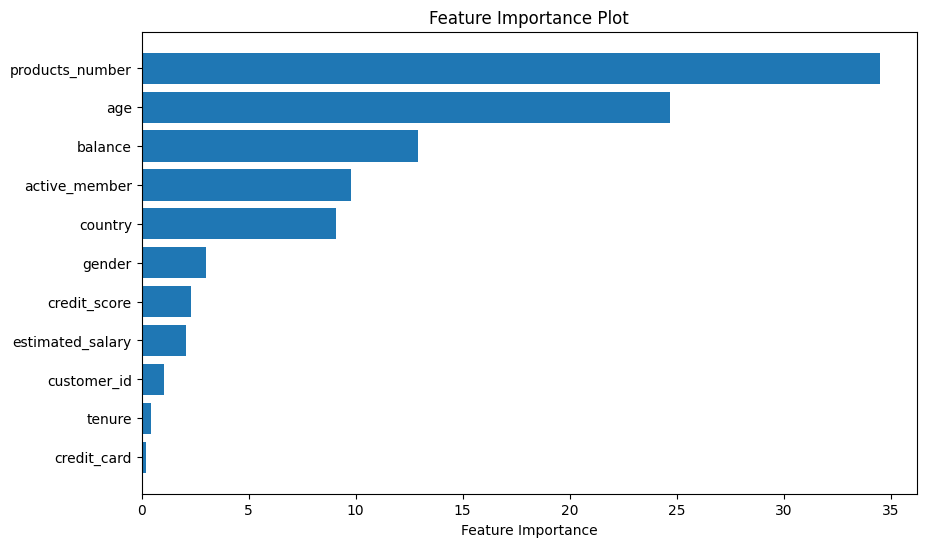

In [97]:
feature_importance = model.get_feature_importance()
feature_names = X_train.columns
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx], align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')

plt.show()

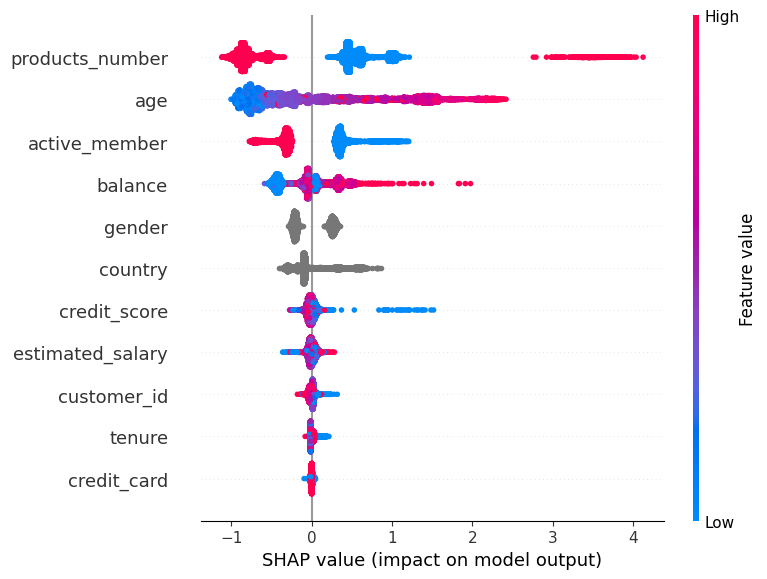

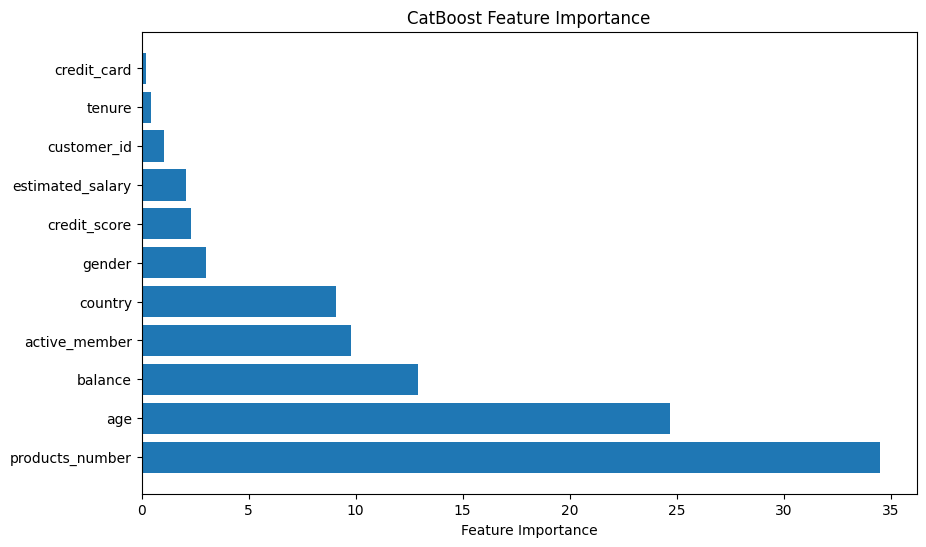

In [99]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train)

plt.figure(figsize=(10, 6))
feature_importance = model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)[::-1]
plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

In [100]:
rf = data.copy()

In [101]:
rf.select_dtypes(include=['number']).columns

Index(['customer_id', 'credit_score', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary',
       'churn'],
      dtype='object')

In [102]:
bank_data = rf[['credit_score', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary',
       'churn']]

from sklearn.feature_selection import RFECV

def bank_model_(data):
    bank_df = bank_data.copy()

    X = bank_df.drop(['churn'], axis=1)
    y = bank_df['churn']

    model = CatBoostClassifier(random_state=123, 
                           depth=2,
                           iterations=100, 
                           eval_metric='AUC', 
                           verbose=0)
    selector = RFECV(estimator=model, 
                 step=1, 
                 cv=3, 
                 scoring='roc_auc', 
                 verbose=1)
    selector.fit(X, y)
    selected_features = X.columns[selector.support_]
    
    return model, selector, selected_features
    
model, selector, selected_features = bank_model_(data)
print('Selected Features:', selected_features.to_list())

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Selected Features: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'active_member', 'estimated_salary']


# Task №5: 🤖 Стекинг моделей

In [103]:
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [104]:
X = data.drop('churn', axis=1)
y = data['churn']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

target_encoder = ce.TargetEncoder(cols=['country', 'gender'])
X_encoded = target_encoder.fit_transform(X, y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)

for model in [log_reg, rf, knn]:
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    print(f"{model.__class__.__name__} AUC: {auc:.3f}")

catboost_model = CatBoostClassifier(max_depth=3, n_estimators=100, silent=True)

stacking_model = StackingClassifier(
    estimators=[('log_reg', log_reg), ('rf', rf), ('knn', knn)],
    final_estimator=catboost_model
)

stacking_model.fit(X_train, y_train)
y_prob_stacking = stacking_model.predict_proba(X_test)[:, 1]
auc_stacking = roc_auc_score(y_test, y_prob_stacking)
print(f"Stacking model AUC: {auc_stacking:.3f}")

LogisticRegression AUC: 0.745
RandomForestClassifier AUC: 0.854
KNeighborsClassifier AUC: 0.528
Stacking model AUC: 0.862


# Task №6: 🗂 **Задача регрессии**

In [105]:
wine_data = pd.read_csv("winequality-white.csv", delimiter=';')
print(wine_data.shape)
wine_data.head(3)

(4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


**чтобы было понятнее, у меня target это качество вина "quality" от 0-10, где 0 это худшее а 10 это лучше качество. И еще, в датасете не имеются категориальные характеристики, если что**

In [106]:
X = wine_data.drop(['quality'], axis=1)
y = wine_data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

model = CatBoostRegressor(silent=True, iterations=200, learning_rate=0.1, depth=4, loss_function='RMSE')
model.fit(train_pool)

In [107]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

MAE: 0.528195329249914
MSE: 0.4508368832865961
RMSE: 0.6714438794766068


# Task №7: 🎯 **Анализ таргета по диапазонам**

In [108]:
print("Min value in y_test:", y_test.min())
print("Max value in y_test:", y_test.max())

Min value in y_test: 3
Max value in y_test: 8


In [110]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
bins = [3, 4, 5, 6, 7, 8]  
labels = [f"{bins[i]} - {bins[i+1]}" for i in range(len(bins)-1)]

y_test_buckets = pd.cut(y_test, bins=bins, labels=labels, include_lowest=True)

metrics = {'Bucket': [], 'Count': [], 'RMSE': [], 'MAE': [], 'MAPE': []}

for bucket in y_test_buckets.cat.categories:
    bucket_indices = y_test_buckets == bucket
    sample_count = bucket_indices.sum()
    
    if sample_count > 0:
        y_true_bucket = y_test[bucket_indices]
        y_pred_bucket = y_pred[bucket_indices]
        
        rmse_bucket = mean_squared_error(y_true_bucket, y_pred_bucket, squared=False)
        mae_bucket = mean_absolute_error(y_true_bucket, y_pred_bucket)
        mape_bucket = mape(y_true_bucket, y_pred_bucket)
        
        metrics['Bucket'].append(bucket)
        metrics['Count'].append(sample_count)
        metrics['RMSE'].append(round(rmse_bucket, 2))
        metrics['MAE'].append(round(mae_bucket, 2))
        metrics['MAPE'].append(round(mape_bucket, 2))


metrics_df = pd.DataFrame(metrics)

metrics_df

,Bucket,Count,RMSE,MAE,MAPE
0,3 - 4,30,1.46,1.31,35.87
1,4 - 5,291,0.63,0.53,10.61
2,5 - 6,432,0.44,0.36,6.00
3,6 - 7,192,0.73,0.62,8.90
4,7 - 8,35,1.45,1.39,17.40


# Task №8: 📈 **Сравнение с базовой моделью**

In [115]:
mean_prediction = np.full(y_test.shape, y_train.mean())

rmse_catboost = mean_squared_error(y_test, y_pred, squared=False)
mae_catboost = mean_absolute_error(y_test, y_pred)
mape_catboost = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

rmse_mean = mean_squared_error(y_test, mean_prediction, squared=False)
mae_mean = mean_absolute_error(y_test, mean_prediction)
mape_mean = np.mean(np.abs((y_test - mean_prediction) / y_test)) * 100

# print("CatBoost Model Metrics:")
# print("RMSE:", rmse_catboost)
# print("MAE:", mae_catboost)
# print("MAPE:", mape_catboost)

# print("\nMean Prediction Model Metrics:")
# print("RMSE:", rmse_mean)
# print("MAE:", mae_mean)
# print("MAPE:", mape_mean)

metrics_data = {
    'Model': ['CatBoost', 'Mean Prediction'],
    'RMSE': [rmse_catboost, rmse_mean],
    'MAE': [mae_catboost, mae_mean],
    'MAPE': [mape_catboost, mape_mean]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df

,Model,RMSE,MAE,MAPE
0,CatBoost,0.671444,0.528195,9.258530
1,Mean Prediction,0.880650,0.674979,11.910868
